In [43]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import csv

from Generator import Generator
from Normalizer import Normalizer
from RealData import RealData

import matplotlib.pyplot as plt
np.set_printoptions(suppress = True)

In [72]:
run = 10

In [45]:
def save(model, recipe_normalizer, quant_normalizer, accs):
    model.save(f"./models/{run}_rank_{rank}/{run}_rank_{rank}.h5")
    
    np.savetxt(f"./models/{run}_rank_{rank}/norm_recipe_max", recipe_normalizer.feature_max)
    np.savetxt(f"./models/{run}_rank_{rank}/norm_recipe_min", recipe_normalizer.feature_min)
    
    np.savetxt(f"./models/{run}_rank_{rank}/norm_quant_max", quant_normalizer.feature_max)
    np.savetxt(f"./models/{run}_rank_{rank}/norm_quant_min", quant_normalizer.feature_min)
    
    
    # open file for writing, "w" is writing
    w = csv.writer(open(f"./models/{run}_rank_{rank}/accuracy.csv", "w"))

    # loop over dictionary keys and values
    for key, val in accs.items():

        # write every key and value to file
        w.writerow([key, val])

## Parameters

#### Data Generation

In [46]:
rank = True

train_examples = 100000
test_examples = 100

#### Model

In [47]:
embed_dim = 1024                          
stack = 6                                    

optimizer = keras.optimizers.Nadam()        
loss = keras.losses.MSE


metrics = keras.metrics.MeanSquaredError()

#### Training

In [48]:
batch_size = 128
epochs = 1000

validation_split = 0.2
verbose = 2

## Generate Data

In [50]:
generator = Generator('./data/nutrients.csv') # filename with data
generator.generate(train_examples) # generates arg number of examples

In [51]:
if rank:
    generator.rank()
    
recipes = generator.recipes
quant = generator.quant
    
recipe_normalizer = Normalizer()
recipe_normalizer.fit(recipes)
recipes = recipe_normalizer.normalize(recipes)

quant_normalizer = Normalizer()
quant_normalizer.fit(quant)
quant = quant_normalizer.normalize(quant)


## Build Model

In [52]:
embed_dim = embed_dim
stack = stack
i1 = keras.layers.Input(generator.recipes.shape[1:])
f1 = keras.layers.Flatten()(i1)
y1 = keras.layers.Dense(embed_dim)(f1)

# Stack residual blocks (skip connections)
for i in range(stack):
    y2 = y1
    y1 = keras.layers.Dense(embed_dim,
        activation=keras.activations.relu)(y1)
    y1 = keras.layers.Add()([y1,y2])
    y1 = keras.layers.LayerNormalization()(y1)
    
        
o1 = keras.layers.Dense(quant.shape[1],activation=keras.activations.softplus)(y1)
    
model = keras.Model(i1,o1)

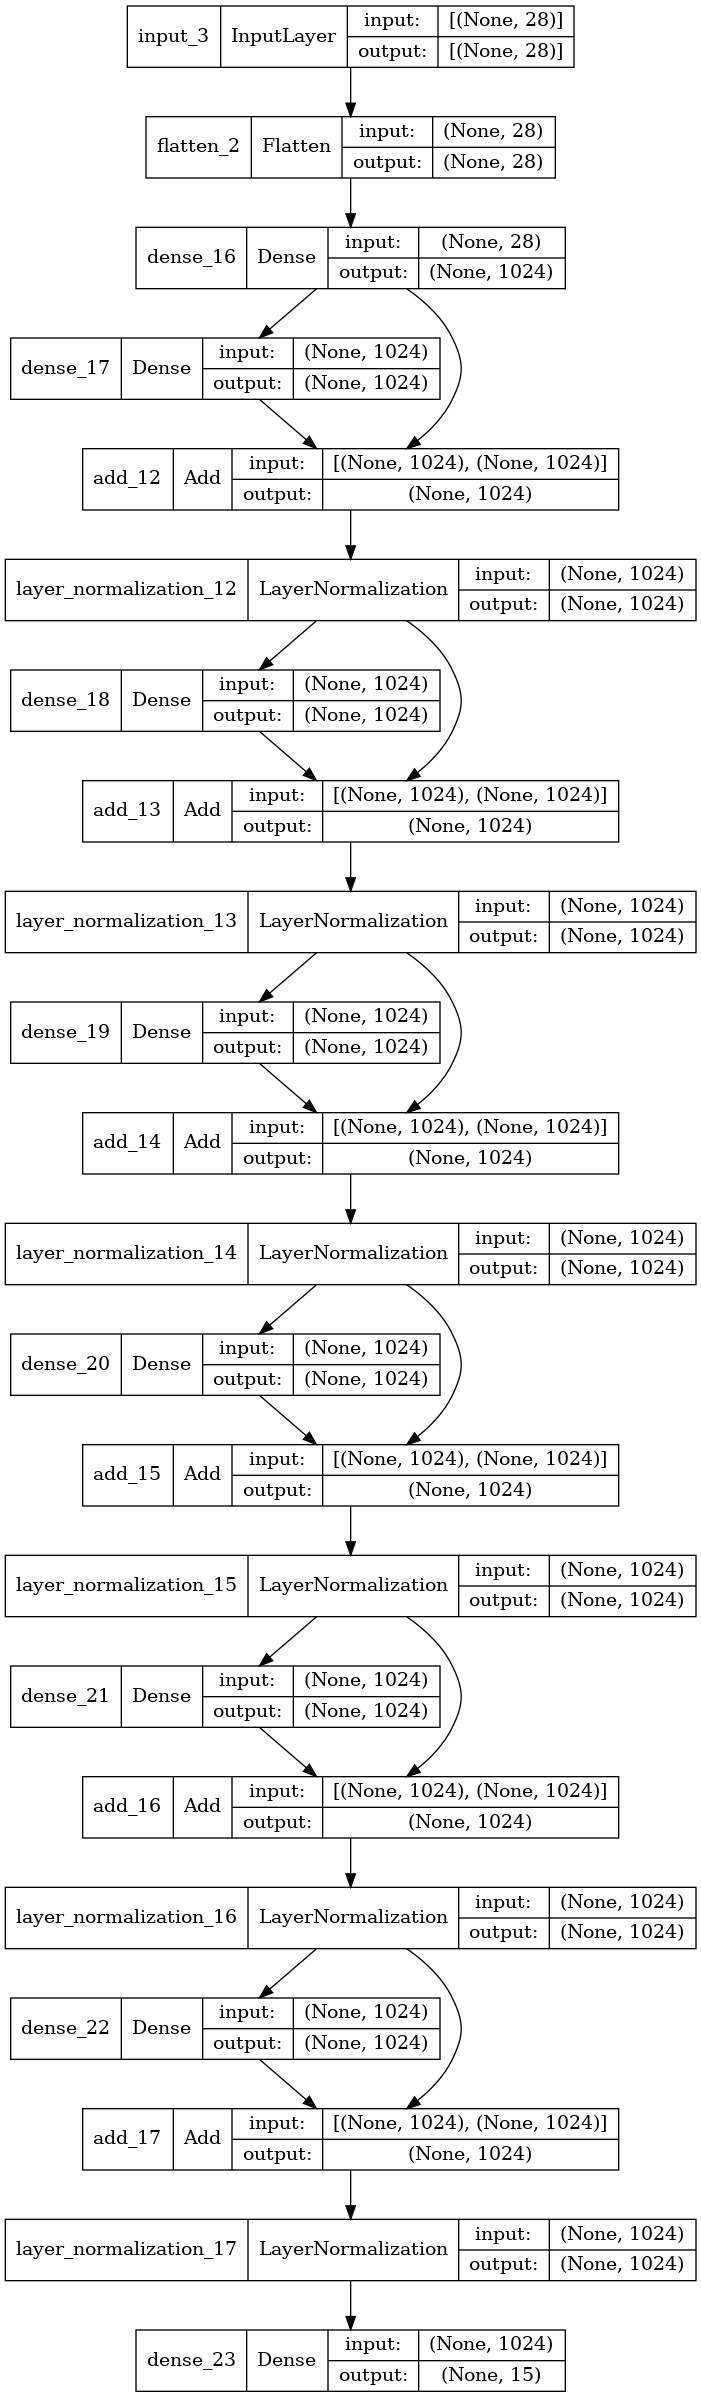

In [53]:
keras.utils.plot_model(model,to_file='recipe_model.png',show_shapes=True,expand_nested=True)

In [54]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28)]         0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 28)           0           ['input_3[0][0]']                
                                                                                                  
 dense_16 (Dense)               (None, 1024)         29696       ['flatten_2[0][0]']              
                                                                                                  
 dense_17 (Dense)               (None, 1024)         1049600     ['dense_16[0][0]']               
                                                                                            

In [55]:
model.compile(optimizer=optimizer,
            loss=loss,
            metrics=metrics)

In [56]:
filepath = f"./models/{run}_rank_{rank}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', save_freq=250)
callbacks_list = [checkpoint]

## Train

In [57]:
history = model.fit(
    recipes, quant, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split = validation_split, 
    verbose=verbose,
    callbacks = callbacks_list
)

Epoch 1/1000


KeyboardInterrupt: 

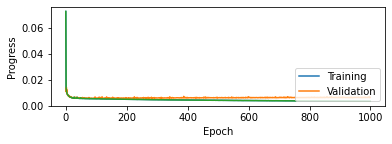

In [58]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['loss'])
plt.ylabel('Progress')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')

## Accuracy Function Definition

In [60]:
# accuracy formula:
#   measured values < 1 are set to 1
#   error = 100(( |Measured Value - Given Value| ) / max(Measured Value, Given Value))
#   accuracy = 100 - error
def accuracy(pred, actual):
    
    accs = {}
    totals = []
    
    for i in range(pred.shape[0]): # for each recipe
        recipe_accs = np.zeros((pred.shape[1])) # last element for accuracy across all ingrs
        recipe_tot = {}
        
        for j in range(pred.shape[1]): # for each ingredient
            measured_ingr = pred[i,j]
            given_ingr = actual[i,j]
            
            if given_ingr < 1:
                given_ingr = 1 # avoid divide by 0 error
            if measured_ingr < 1:
                measured_ingr = 1
            
            
            error = 100 * abs(measured_ingr - given_ingr)/max(given_ingr,measured_ingr)
            accuracy = round(abs(100 - error),2)
            
            
            if (accuracy < 0):
                accuracy = 0
            
            recipe_accs[j] = accuracy
        
        accs[f"{i}_mape"] = round((np.sum(recipe_accs) / recipe_accs.shape[0]),2)
        accs[f"{i}_ingrs"] = recipe_accs
        

        
    return accs

## Testing Fake Data

In [61]:
test_gen = Generator('./data/nutrients.csv')
test_gen.generate(test_examples) # generates arg number of examples

if rank:
    test_gen.rank()
    
test_recipes = test_gen.recipes
test_quant = test_gen.quant
    
test_recipes = recipe_normalizer.normalize(test_recipes)
test_quant = quant_normalizer.normalize(test_quant)

In [62]:
pred = model.predict(test_recipes)
pred = quant_normalizer.inv_normalize(pred)

In [63]:
actual = test_gen.quant

In [64]:
index = 5
for i in range(len(pred[0])):
    pred_num = str(round(pred[index,i],3))
    act_num = str(round(actual[index,i],3))
    
    print(f"pred: {pred_num} | actual: {act_num}" )

pred: 0.012 | actual: 163.736
pred: 0.007 | actual: 106.536
pred: 0.0 | actual: 30.62
pred: 0.298 | actual: 667.612
pred: 0.089 | actual: 0.0
pred: 0.0 | actual: 23.821
pred: 0.643 | actual: 0.0
pred: 0.001 | actual: 0.0
pred: 73.844 | actual: 0.0
pred: 9.215 | actual: 0.0
pred: 4.183 | actual: 18.328
pred: 0.622 | actual: 0.0
pred: 6.908 | actual: 0.0
pred: 0.0 | actual: 0.0
pred: 0.0 | actual: 0.0


## Testing Real Data

In [65]:
recipe_quant = "./data/Recipe Data.csv"
ingr_nutr = "./data/nutrients.csv"

In [66]:
realdata = RealData(recipe_quant,ingr_nutr)

In [67]:
if rank:
    realdata.rank()

real_recipes = realdata.recipes
real_quant = realdata.quant
    
real_recipes = recipe_normalizer.normalize(real_recipes)

In [68]:
pred = model.predict(real_recipes)
pred = quant_normalizer.inv_normalize(pred)

In [69]:
actual = realdata.quant

In [70]:
index = 10
for i in range(len(pred[0])):
    pred_num = str(round(pred[index,i],3))
    act_num = str(round(actual[index,i],3))
    
    print(f"pred: {pred_num} | actual: {act_num}" )

pred: 0.01 | actual: 5.6
pred: 0.008 | actual: 59.0
pred: 0.0 | actual: 5.7
pred: 0.274 | actual: 374.0
pred: 0.204 | actual: 28.0
pred: 0.0 | actual: 25.2
pred: 4.846 | actual: 49.6
pred: 0.001 | actual: 0.0
pred: 49.063 | actual: 0.0
pred: 6.028 | actual: 0.0
pred: 2.247 | actual: 0.0
pred: 0.484 | actual: 0.0
pred: 7.08 | actual: 0.0
pred: 0.0 | actual: 0.0
pred: 0.001 | actual: 180.0


In [71]:
accs = accuracy(pred,actual)

In [29]:
save(model,recipe_normalizer,quant_normalizer, accs)